# Install Library

In [3]:
!pip install opencv-python mplsoccer --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 3.1 MB/s eta 0:00:00


# Import Library

In [7]:
import os
import cv2
import yaml
import pandas as pd
import seaborn as sns
from mplsoccer import Pitch
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Mounted at /content/drive


# EDA (Exploratory Data Analysis)

## Pitch Visualization

kpt_id:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 13, 18]


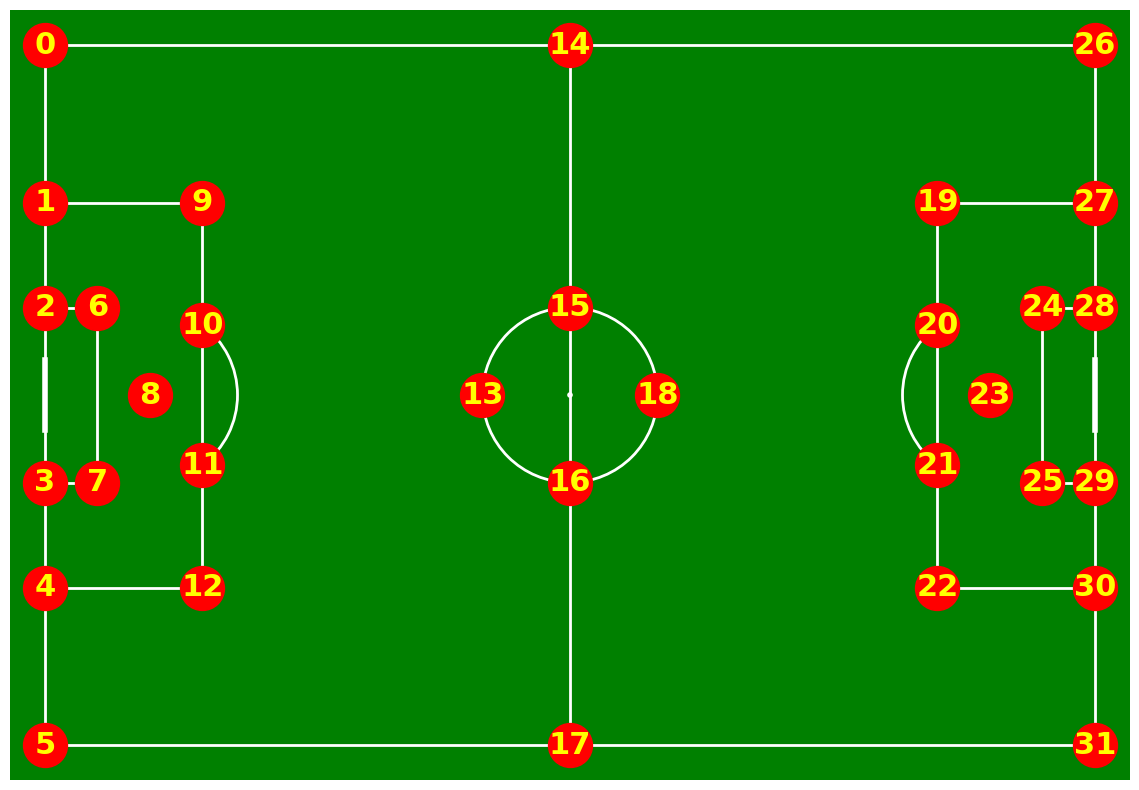

In [9]:
yaml_path = r"/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/data.yaml"
# === Read YAML file for keypoint order ===
with open(yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)
# Get keypoint names from YAML file
kpt_id = data_yaml.get('flip_idx', [])
print("kpt_id: ", kpt_id)

# 1. Create DataFrame from 32 keypoints
# Pixel coordinates are 120 x 80
total_keypoints = 32
data = {
    # 'id': list(range(1, total_keypoints+1)),
    'id': kpt_id,
    'x': [0, 0, 0, 0, 0,
          0, 6, 6, 12, 18,
          18, 18, 18, 60, 60,
          60, 60, 102, 102, 102,
          102, 108, 114, 114, 120,
          120, 120, 120, 120, 120,
          50, 70],
    'y': [0, 18, 30, 50, 62,
          80, 30, 50, 40, 18,
          32, 48, 62, 0, 30,
          50, 80, 18, 32, 48,
          62, 40, 30, 50, 0,
          18, 30, 50, 62, 80,
          40, 40]
}
df_keypoints = pd.DataFrame(data)
# display(df_keypoints)

# 2. Initialize the pitch (field)
pitch = Pitch(pitch_color='green', line_color='white')
fig, ax = pitch.draw(figsize=(12, 8))

# 3. Scatter and annotate from DataFrame
pitch.scatter(df_keypoints['x'], df_keypoints['y'], ax=ax, color='red', s=1000)
for _, row in df_keypoints.iterrows():
    ax.text(row['x'], row['y'], str(row['id']), ha='center', va='center', color='yellow', fontsize=22, weight='bold')

# plt.title("32 Keypoints Soccer Pitch", fontsize=16)
plt.show()


## Distribution of the keypoints

df_raw:


,filename,keypoint_index,x,y,v
0,08fd33_2_2_png_jpg.rf.671af5454deaac01b7e82366...,0,0.023809,0.316084,0.0
1,08fd33_2_2_png_jpg.rf.671af5454deaac01b7e82366...,1,0.023809,0.469616,0.0
2,08fd33_2_2_png_jpg.rf.671af5454deaac01b7e82366...,2,0.023809,0.545384,0.0
3,08fd33_2_2_png_jpg.rf.671af5454deaac01b7e82366...,3,0.023809,0.700911,0.0
4,08fd33_2_2_png_jpg.rf.671af5454deaac01b7e82366...,4,0.021011,0.775930,0.0
...,...,...,...,...,...
12859,worldcup2_680_jpg.rf.0c905cca2fa28caca1ef10d81...,27,0.853183,0.510542,0.0
12860,worldcup2_680_jpg.rf.0c905cca2fa28caca1ef10d81...,28,0.905646,0.531600,0.0
12861,worldcup2_680_jpg.rf.0c905cca2fa28caca1ef10d81...,29,0.995113,0.619064,0.0
12862,worldcup2_680_jpg.rf.0c905cca2fa28caca1ef10d81...,30,0.000130,0.000133,0.0


,v,count
0,0.0,7915
1,1.0,11
2,2.0,4938


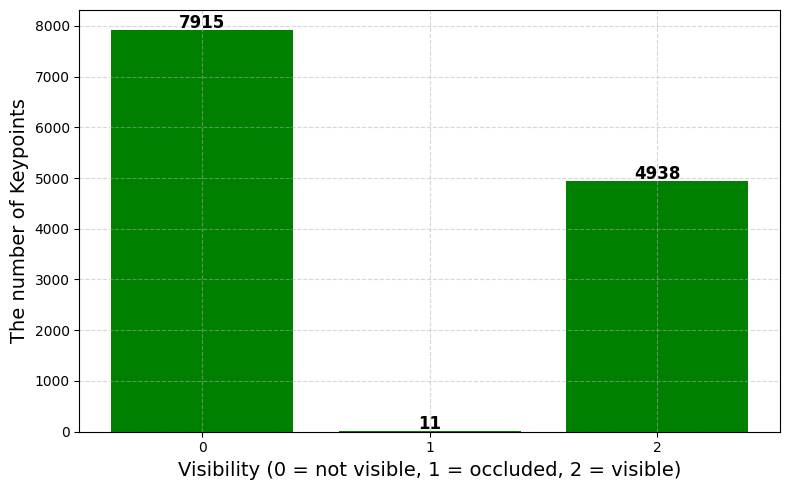



=== VISIBILITY 0, 1, 2 ===


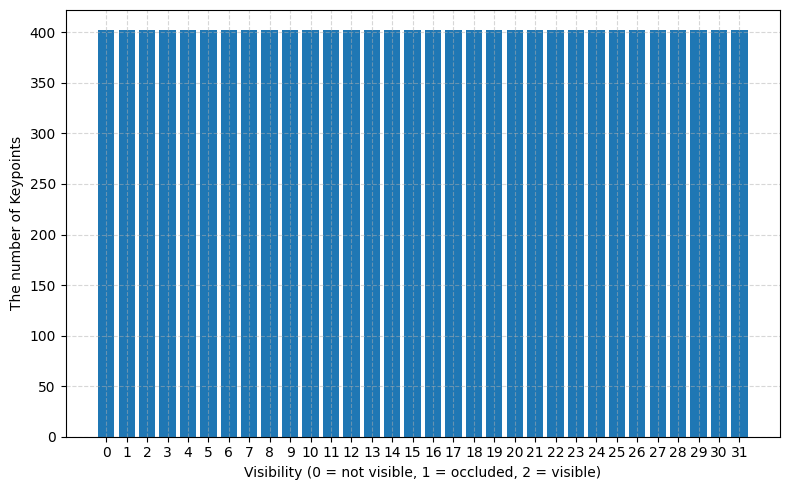



=== VISIBILITY 0 ===


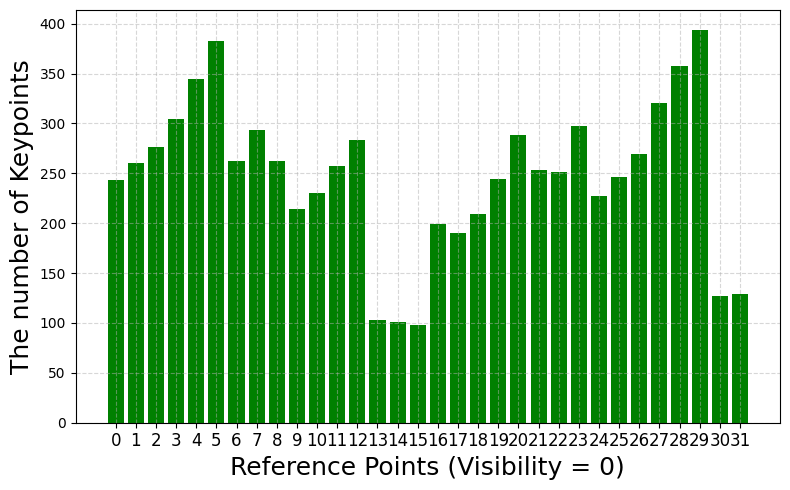



=== VISIBILITY 1 ===


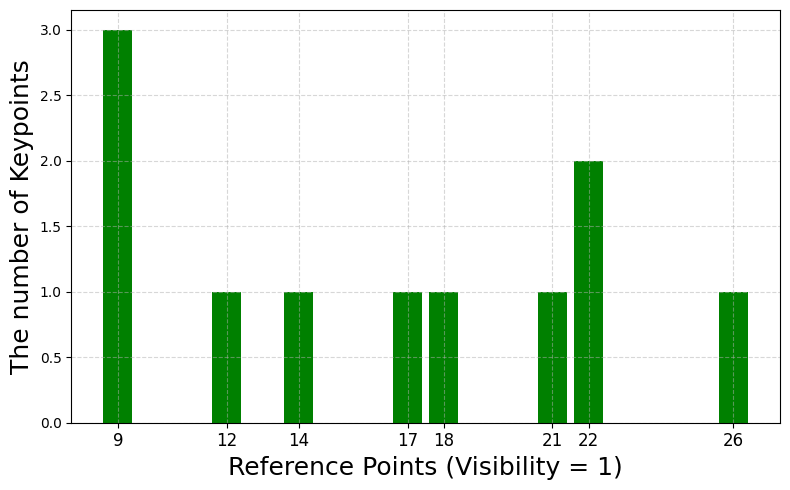



=== VISIBILITY 2 ===


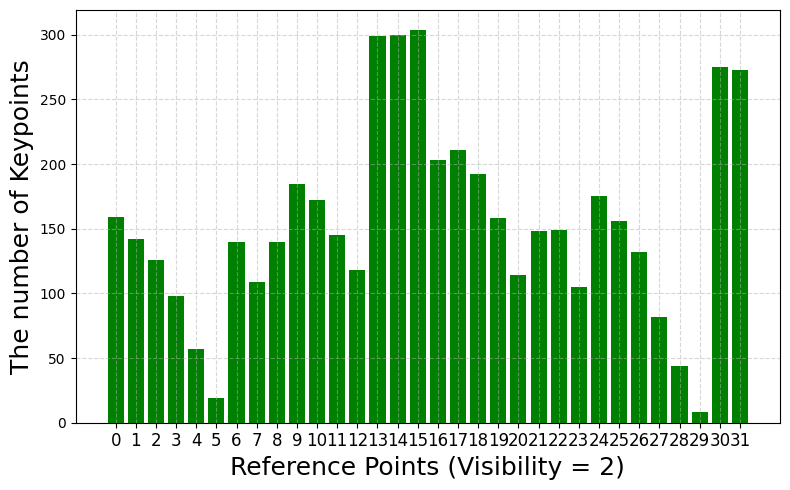

In [13]:
# === PATH TO LABEL FOLDER ===
label_folder = r"/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/train/labels"

# === Collect raw data into a list ===
records = []

for fname in os.listdir(label_folder):
    if fname.endswith('.txt'):
        with open(os.path.join(label_folder, fname), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 6:
                    continue  # Ignore rows without keypoints
                keypoints = list(map(float, parts[5:]))
                for i in range(len(keypoints) // 3):
                    x = keypoints[i * 3]
                    y = keypoints[i * 3 + 1]
                    v = keypoints[i * 3 + 2]
                    records.append({
                        'filename': fname,
                        'keypoint_index': i,
                        'x': x,
                        'y': y,
                        'v': v
                    })

# === Create raw DataFrame ===
df_raw = pd.DataFrame(records)

# === Display sample DataFrame content ===
print("df_raw:")
display(df_raw)

# === Data per Visibility ===
df_vis = df_raw.groupby('v').size().reset_index(name='count')
display(df_vis)
# === Plot with matplotlib ===
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(df_vis['v'].astype(int), df_vis['count'], color="green")
# === Label and grid ===
# ax.set_title('Visibility distribution (v) from Keypoints')
ax.set_xlabel('Visibility (0 = not visible, 1 = occluded, 2 = visible)', fontsize=14)
ax.set_ylabel('The number of Keypoints', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.5)
# === Add count labels above bars ===
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 50,
            f'{int(height)}', ha='center', fontsize=12, fontweight='bold')
plt.xticks([0, 1, 2])  # Ensure order and consistency
plt.tight_layout()
plt.show()


# === Data from groupby ===
# df_vis = df_raw[(df_raw['v']==2)|(df_raw['v']==0)].groupby('keypoint_index').size().reset_index(name='count')
df_vis = df_raw.groupby('keypoint_index').size().reset_index(name='count')
print("\n\n=== VISIBILITY 0, 1, 2 ===")
# display(df_vis)
# === Plot with matplotlib ===
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(df_vis['keypoint_index'].astype(int), df_vis['count'])
# === Label and grid ===
# ax.set_title('Keypoint Distribution for All Visibility')
ax.set_xlabel('Visibility (0 = not visible, 1 = occluded, 2 = visible)')
ax.set_ylabel('The number of Keypoints')
ax.grid(True, linestyle='--', alpha=0.5)
plt.xticks(df_vis['keypoint_index'])  # to make it consistent
plt.tight_layout()
plt.show()

# === Data from groupby ===
for i in range(3):
    print(f"\n\n=== VISIBILITY {i} ===")
    df_vis = df_raw[(df_raw['v']==i)].groupby('keypoint_index').size().reset_index(name='count')
    # display(df_vis)
    # === Plot with matplotlib ===
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(df_vis['keypoint_index'].astype(int), df_vis['count'], color="green")
    # === Label and grid ===
    # ax.set_title('Keypoint Distribution for Visibility ' + str(i))
    ax.set_xlabel(f'Reference Points (Visibility = {i})', fontsize=18)
    ax.set_ylabel('The number of Keypoints', fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.5)
    # ax.tick_params(axis='both', which='major', labelsize=11)
    plt.xticks(df_vis['keypoint_index'], fontsize=12)  # to make it consistent
    plt.tight_layout()
    plt.show()

## Percentage of each keypoint

,id,x,y,keypoint_index,count,percentage
0,0,0,0,0,402,3.12
1,1,0,18,1,402,3.12
2,2,0,30,2,402,3.12
3,3,0,50,3,402,3.12
4,4,0,62,4,402,3.12
5,5,0,80,5,402,3.12
6,6,6,30,6,402,3.12
7,7,6,50,7,402,3.12
8,8,12,40,8,402,3.12
9,9,18,18,9,402,3.12


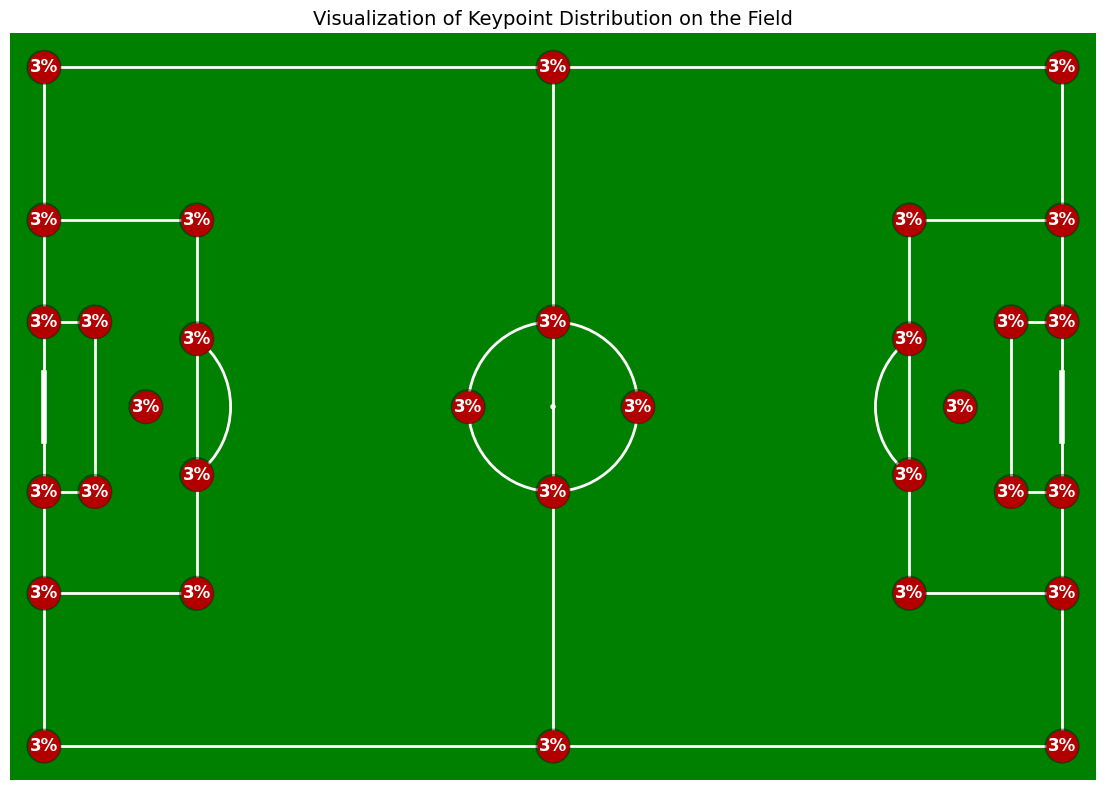

In [14]:
# === PATH TO LABEL FOLDER ===
label_folder = r"/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/train/labels"

# === Collect raw data into a list ===
records = []

for fname in os.listdir(label_folder):
    if fname.endswith('.txt'):
        with open(os.path.join(label_folder, fname), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 6:
                    continue  # ignore lines without keypoints
                keypoints = list(map(float, parts[5:]))
                for i in range(len(keypoints) // 3):
                    x = keypoints[i * 3]
                    y = keypoints[i * 3 + 1]
                    v = keypoints[i * 3 + 2]
                    records.append({
                        'filename': fname,
                        'keypoint_index': i,
                        'x': x,
                        'y': y,
                        'v': v
                    })

# === Create raw DataFrame ===
df_raw = pd.DataFrame(records)
df_vis = df_raw.groupby('keypoint_index').size().reset_index(name='count')

# --- Keypoint pixel positions on the field (120x80) ---
total_keypoints = 32
df_keypoints = pd.DataFrame({
    'id': list(range(total_keypoints)),
    'x': [0, 0, 0, 0, 0,
          0, 6, 6, 12, 18,
          18, 18, 18, 50, 60,
          60, 60, 60, 70, 102,
          102, 102, 102, 108, 114,
          114, 120, 120, 120, 120,
          120, 120],
    'y': [0, 18, 30, 50, 62,
          80, 30, 50, 40, 18,
          32, 48, 62, 40, 0,
          30, 50, 80, 40, 18,
          32, 48, 62, 40, 30,
          50, 0, 18, 30, 50,
          62, 80]
})

# --- Merge positions with frequencies ---
df_plot = pd.merge(df_keypoints, df_vis, left_on='id', right_on='keypoint_index', how='left')
df_plot['count'] = df_plot['count'].fillna(0)  # fill missing values
df_plot['percentage'] = df_plot['count'] / df_plot['count'].sum() * 100
df_plot['percentage'] = df_plot['percentage'].round(2)
display(df_plot)

# --- Draw pitch and display keypoint counts on top of each point ---
pitch = Pitch(pitch_color='green', line_color='white')
fig, ax = pitch.draw(figsize=(12, 8))

# Draw keypoint dots
pitch.scatter(df_plot['x'], df_plot['y'], ax=ax, color='red', s=500)

# Add circles & percentage text above each keypoint
for _, row in df_plot.iterrows():
    # Draw a small circle around each point
    circle = plt.Circle((row['x'], row['y']), radius=2, color='black', alpha=0.3, zorder=3)
    ax.add_patch(circle)

    # Add text label at the center of each circle
    ax.text(row['x'], row['y'], str(int(row['percentage'])) + '%',
            color='white', fontsize=12, ha='center', va='center', zorder=4, weight='bold')

plt.title("Visualization of Keypoint Distribution on the Field", fontsize=14)
plt.show()

## Check the keypoints on the actual frame

In [15]:
# === Folder configuration ===
label_folder = r"/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/train/labels"
image_folder = r"/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/train/images"
yaml_path = r"/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/data.yaml"

# === Read YAML file for keypoint order ===
with open(yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)

# Get keypoint names from YAML file
keypoint_names = data_yaml.get('flip_idx', [])

# === Extract keypoints from YOLO label files ===
records = []

# === Loop through each label file ===
for fname in os.listdir(label_folder):
    if fname.endswith('.txt'):
        with open(os.path.join(label_folder, fname), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 6:
                    continue
                keypoints = list(map(float, parts[5:]))
                # print(f"Processing {fname}: {len(keypoints) // 3} keypoints found.")
                for i in range(len(keypoints) // 3):
                    x = keypoints[i * 3]
                    y = keypoints[i * 3 + 1]
                    v = keypoints[i * 3 + 2]
                    records.append({
                        'filename': fname.replace('.txt', '.jpg'),  # Change to image filename
                        'keypoint_name': keypoint_names[i] if i < len(keypoint_names) else f"kp_{i}",
                        'x': x,
                        'y': y,
                        'v': v
                    })

df_raw = pd.DataFrame(records)
# display(df_raw)

# === Select images to visualize ===
unique_filenames = df_raw['filename'].unique()[:10]
# unique_filenames = ['42ba34_1_2_png_jpg.rf.58f83fd1b2cf77dbbf1a91194fafa04e.jpg']

# === Visualize keypoints on images ===
for img_name in unique_filenames:
    print(f"Displaying: {img_name}")
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Image file not found: {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_kps = df_raw[df_raw['filename'] == img_name].copy()
    # === Display DataFrame for the selected image ===
    # display(img_kps)

    # === Plot image and keypoints ===
    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    for _, row in img_kps.iterrows():
        x_px = int(row['x'] * img.shape[1])
        y_px = int(row['y'] * img.shape[0])

        if row['v'] == 2:
            color = 'red'
            plt.plot(x_px, y_px, 'o', color=color)
            plt.text(x_px + 3, y_px - 3, f"{row['keypoint_name']}", color='cyan', fontsize=7)
        # elif row['v'] == 1:
        #     color = 'yellow'
        # else:
        #     color = 'gray'

        # plt.plot(x_px, y_px, 'o', color=color)
        # plt.text(x_px + 3, y_px - 3, f"{row['keypoint_name']}", color='cyan', fontsize=7)

    plt.title(img_name)
    plt.axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.